<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab11-autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11 - Autoencoders
### Author: Szymon Nowakowski


# Introduction
--------------

Autoencoders can be thought of as nonlinear extensions of PCA. In this class, we’ll train an autoencoder on the MNIST dataset and compare its encoded representation to the PCA space we constructed earlier (remember our very first class?). This comparison will help us see whether the autoencoder captures the structure of the data more effectively.

Next, we’ll put the trained autoencoder to practical use. It is great in anomaly detection (identification of outliers) and image denoising.

You’ll also notice that throughout this class, we’re treating the images in a class-diagnostic, unsupervised manner—focusing on the structure of the data itself, rather than on labels.

# Deterministic output
--------------------------------



In [1]:
import torch

SEED = 0

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


# Reading MNIST Dataset
----------------------------------

In [2]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.ToTensor() #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

     # note - we are NOT normalizing pixels, as we want to keep 0-1 range)

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


# Tensor Sizes
-------------------

Recall:
- Batched labels are of order one. The first (and only) index is a sample index within a batch.
- Image batches have order 4. The first index is a sample index within a batch, but a second index has size 1 and thus it is always 0.
  - This index represents a Channel number inserted here by `ToTensor()` transformation, always 0.
  - It should be retained because we want to use convolutional layers, which explicitly require this order. For RGB images we have 3 channels, for B&W images we have only one channel.


# Encoder and Decoder Networks
-----------------

Autoencoder is an Encoder followed by a Decoder, as in this diagram: ![Autoencoder](https://github.com/SzymonNowakowski/Machine-Learning-2024/raw/master/autoencoder_diagram.png
)

Both Encoder and Decoder components are typically CNN neural networks.

We will base their structure on LeNet5 neural network. As a reminder, we worked with the LeNet-5 network in our previous class. You can revisit its definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


## Encoder

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder_just_as_LeNet5(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)      # 1x28x28 -> 6x24x24
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                        # 6x24x24 -> 6x12x12

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)     # 6x12x12 -> 16x8x8
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)                        # 16x8x8  -> 16x4x4

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4)   # 16x4x4 ->  120x1x1

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=bottleneck_dimensionality)

        # Optional dropout
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        # Convolutional feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))  # Output: (batch_size, 120, 1, 1)

        x = torch.flatten(x, 1)  # Flatten to (batch_size, 120)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #x = self.dropout(x)

        return x


## Decoder

In [4]:

class Decoder_just_as_LeNet5(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()

        # Fully connected layers (reverse of encoder)
        self.fc2 = nn.Linear(bottleneck_dimensionality, 84)
        self.fc1 = nn.Linear(84, 120)

        # Reverse conv3: going from (120, 1, 1) to (16, 4, 4)
        self.deconv3 = nn.ConvTranspose2d(in_channels=120, out_channels=16, kernel_size=4)  # 120x1x1 -> 16x4x4

        # Unpool + deconv2: 16x4x4 -> 6x12x12
        self.unpool2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 16x4x4 -> 16x8x8
        self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5)     # 16x8x8 -> 6x12x12

        # Unpool + deconv1: 6x12x12 -> 1x28x28
        self.unpool1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 6x12x12 -> 6x24x24
        self.deconv1 = nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5)      # 6x24x24 -> 1x28x28

    def forward(self, x):
        # Fully connected layers (reverse)
        x = F.relu(self.fc2(x))
        x = self.fc1(x)

        # Reshape to match the shape before flattening in encoder
        x = x.view(-1, 120, 1, 1)

        # Transposed convolutions with upsampling (reverse conv layers)
        x = F.relu(self.deconv3(x))   # -> (16, 4, 4)
        x = self.unpool2(x)           # -> (16, 8, 8)
        x = F.relu(self.deconv2(x))   # -> (6, 12, 12)
        x = self.unpool1(x)           # -> (6, 24, 24)
        x = torch.sigmoid(self.deconv1(x))  # -> (1, 28, 28), output in [0, 1]

        return x


### Notes on Decoder Design

- `Upsample` is used to simulate the inverse of `AvgPool2d`. It’s not a perfect inversion, but it restores the spatial dimensions to the correct shape.

- `ConvTranspose2d` inverts the effect of `Conv2d`, expanding the feature map size as a mirror operation of the encoder.

- `torch.sigmoid` at the end brings output values into the range `[0, 1]`, which is suitable for grayscale image reconstruction.

## Autoencoder


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()
        self.encoder = Encoder_just_as_LeNet5(bottleneck_dimensionality)
        self.decoder = Decoder_just_as_LeNet5(bottleneck_dimensionality)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training Loop
----------------------

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

# Create model and optimizer
net = Autoencoder(bottleneck_dimensionality=2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

EPOCHS = 64
loss_history = []

# Training loop
net.train()
for epoch in range(EPOCHS):
    epoch_loss_sum = 0.0
    epoch_sample_count = 0

    for batch_idx, (batch_inputs, _) in enumerate(trainloader):
        batch_inputs = batch_inputs.to(device)

        optimizer.zero_grad()
        reconstructed = net(batch_inputs)

        # Per-sample average loss in batch
        loss = F.mse_loss(reconstructed, batch_inputs, reduction='mean')
        loss.backward()
        optimizer.step()

        batch_size = batch_inputs.size(0)
        epoch_loss_sum += loss.item() * batch_size
        epoch_sample_count += batch_size

        #print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} | Loss: {loss.item():.6f}")

    avg_epoch_loss = epoch_loss_sum / epoch_sample_count
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch} completed. Avg loss: {avg_epoch_loss:.6f}")


Working on cuda
Epoch 0 completed. Avg loss: 0.205569
Epoch 1 completed. Avg loss: 0.109549
Epoch 2 completed. Avg loss: 0.088748
Epoch 3 completed. Avg loss: 0.074997
Epoch 4 completed. Avg loss: 0.070667
Epoch 5 completed. Avg loss: 0.066531
Epoch 6 completed. Avg loss: 0.063592
Epoch 7 completed. Avg loss: 0.062018
Epoch 8 completed. Avg loss: 0.060712
Epoch 9 completed. Avg loss: 0.059743
Epoch 10 completed. Avg loss: 0.058683
Epoch 11 completed. Avg loss: 0.057721
Epoch 12 completed. Avg loss: 0.057059
Epoch 13 completed. Avg loss: 0.056502
Epoch 14 completed. Avg loss: 0.055928
Epoch 15 completed. Avg loss: 0.055380
Epoch 16 completed. Avg loss: 0.054884
Epoch 17 completed. Avg loss: 0.054321
Epoch 18 completed. Avg loss: 0.053734
Epoch 19 completed. Avg loss: 0.053308
Epoch 20 completed. Avg loss: 0.052880
Epoch 21 completed. Avg loss: 0.052677
Epoch 22 completed. Avg loss: 0.052334
Epoch 23 completed. Avg loss: 0.052071
Epoch 24 completed. Avg loss: 0.051822
Epoch 25 completed.

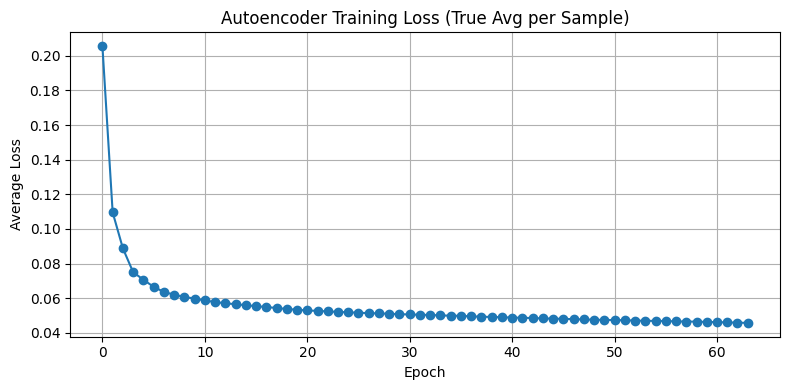

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker='o')
plt.title("Autoencoder Training Loss (True Avg per Sample)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# Visual Testing
----------------------

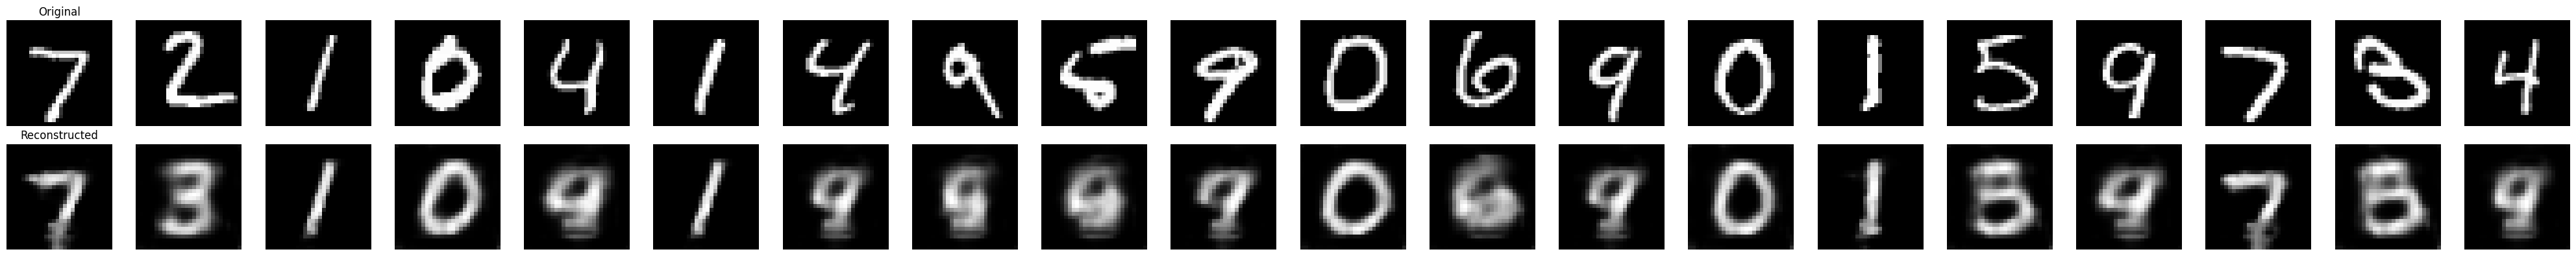

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Number of examples to show
N = 20

net.eval()
fig, axs = plt.subplots(2, N, figsize=(2 * N, 4))

test_iter = iter(testloader)
for i in range(N):
    img, _ = next(test_iter)
    img = img.to(device)

    with torch.no_grad():
        recon = net(img)

    axs[0, i].imshow(img[0, 0].cpu().numpy(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(recon[0, 0].cpu().numpy(), cmap="gray")
    axs[1, i].axis("off")

axs[0, 0].set_title("Original")
axs[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()